### Import the required packages

In [1]:
import requests
import json
import xarray as xr
import datetime
from ipywidgets import interact, widgets, interactive
from IPython.display import display
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import numpy as np
import matplotlib.dates as mdates
pd.set_option('display.max_columns', None)

### Search through species in the three collections.

In [2]:
df_species = pd.read_csv('species_occurences.csv')
species_list = df_species['species'].tolist()

def search_columns(search_term):
    search_term = search_term.lower()
    matches = [col for col in species_list if search_term in col.lower()]

    displayed_matches = set() 
    
    if matches:
        for match in matches:
            if match not in displayed_matches:  
                displayed_matches.add(match)  
                display(df_species.loc[df_species['species'] == match])
    else:
        print("No matching columns found.")

search_columns("subtr") #Enter your search term here

,collection,species,occurrences
6,WMR,subtruncata,170524
118,Aquadesk,subtruncata,3716


,collection,species,occurrences
774,Aquadesk,subtruncatum,65


### Set the input parameters

* Voor invullen van parameter_CTD kiezen uit (vul in hetgeen tussen haakjes): Geleidendheid ('GELDHD'), Temperatuur ('T'),  Globale straling ('GLOBLSLG'), Zuurgraad ('pH'), Saliniteit ('SALNTT'), Monstertijd ('MONSTD'), Fluorescentie ('FLUORCTE'), Verzadigingsgraad ('VERZDGGD'), (Massa)concentratie ('CONCTTE').

* Voor invullen van parameter_WADAR kiezen uit vul in de volledige naam: (Massa)concentratie ('CONCTTE'), Temperatuur ('T'), Massafractie ('MASSFTE'), Geleidendheid ('GELDHD'), Stroomsnelheid ('STROOMSHD'), Windsnelheid ('WINDSHD'), Significante deiningshoogte in het spectrale domein ('HTE3'), Significante golfhoogte in het spectrale domein ('Hm0'), Waterhoogte ('WATHTE'), Debiet ('Q'), Windrichting ('WINDRTG'), Waterhoogte berekend? ('WATHTBRKD').

In [3]:
species = 'subtruncata'
lon_min = 3.8
lon_max = 4.6
lat_min = 52
lat_max = 52.8
start_date = "2016-01-01"
end_date = "2024-01-01"
parameter_CTD = "T"
min_value_CTD = -2
max_value_CTD = 40 
parameter_WADAR = "Temperatuur"
min_value_WADAR = -2
max_value_WADAR = 40 

In [4]:
VIS_body = {
        "query_parameters": [
            {
                "column_name": 'measuredvalue',
                "alias": 'value'
            },
            {
                "column_name": 'Species',
                "alias": 'species'
            },
            {
                "column_name": 'Genus',
                "alias": 'genus'
            },
            {
                "column_name": "measuredunit",
                "alias": "unit"
            },
            {
                "column_name": "quantity",
                "alias": "quantity"
            },
            {
                "column_name": "collectiondate",
                "alias": "date"
            },
            {
                "column_name": "longitude",
                "alias": "longitude"
            },
            {
                "column_name": "latitude",
                "alias": "latitude"
            }],
            "filters": [
            {
              "for_query_parameter": "longitude",
              "min": lon_min,
              "max": lon_max
            },
            {
              "for_query_parameter": "latitude",
              "min": lat_min,
              "max": lat_max
            },
            {
              "for_query_parameter": "species",
              "eq": species
            }
            ],
            "output": {
                "format": "csv"
        }}

In [5]:
VIS_response = requests.post("https://beacon-poc-vis-monitoring.maris.nl/api/query", json.dumps(VIS_body), headers = {
    'Content-type': 'application/json'
})

if VIS_response.status_code == 200:
    open('./Vis.csv', 'wb').write(VIS_response.content)
    df_VIS = pd.read_csv('./Vis.csv', low_memory=False)
    df_VIS['collection'] = 'VIS'
    df_VIS.drop(columns='dataset_id', inplace=True)
    df_VIS['date'] = pd.to_datetime(df_VIS["date"], dayfirst=False)
    df_VIS = df_VIS[(df_VIS['date'] >= start_date) & (df_VIS['date'] <= end_date)]
    df_VIS = df_VIS.sort_values(by='date').reset_index(drop=True)
    print("This is the dataframe generated from the VIS collection."), display(df_VIS)
else:
    df_VIS = pd.DataFrame(columns=['value', 'species', 'genus', 'unit', 'quantity', 'date', 'longitude', 'latitude'])  
    print("No response content, created an empty DataFrame.")

This is the dataframe generated from the VIS collection.


,value,species,genus,unit,quantity,date,longitude,latitude,collection


In [6]:
Aquadesk_noordzee_body = {
        "query_parameters": [
            {
                "column_name": "Waarde_Berekend",
                "alias": "value"
            },
            {
                "column_name": "Species",
                "alias": "species"
            },
            {
                "column_name": 'Genus',
                "alias": 'genus'
            },
            {
                "column_name": "Eenheid_Berekend",
                "alias": "unit"
            },
            {
                "column_name": "Grootheid_Code",
                "alias": "quantity"
            },
            {
                "column_name": 'Meting_DatumTijd',
                "alias": 'date'
            },
            {
                "column_name": "longitude",
                "alias": "longitude"
            },
            {
                "column_name": "latitude",
                "alias": "latitude"
            }
            ],
            "filters": [
            {
              "for_query_parameter": "longitude",
              "min": lon_min,
              "max": lon_max
            },
            {
              "for_query_parameter": "latitude",
              "min": lat_min,
              "max": lat_max
            },
            {
              "for_query_parameter": "species",
              "eq": species
            }
            ],
            "output": {
                "format": "csv"
        }}

In [7]:
Aquadesk_noordzee_response = requests.post("https://beacon-poc-aquadesk-noordzee.maris.nl/api/query", json.dumps(Aquadesk_noordzee_body), headers = {
    'Content-type': 'application/json'
})

if Aquadesk_noordzee_response.status_code == 200:
    open('./Aquadesk_noordzee.csv', 'wb').write(Aquadesk_noordzee_response.content)
    df_Aquadesk_noordzee = pd.read_csv('Aquadesk_noordzee.csv', low_memory=False)
    df_Aquadesk_noordzee['collection'] = 'Aquadesk'
    df_Aquadesk_noordzee.drop(columns='dataset_id', inplace=True)
    df_Aquadesk_noordzee['date'] = df_Aquadesk_noordzee['date'].str.slice(start=1)
    df_Aquadesk_noordzee['date'] = pd.to_datetime(df_Aquadesk_noordzee["date"], dayfirst=True)
    df_Aquadesk_noordzee = df_Aquadesk_noordzee[(df_Aquadesk_noordzee['date'] >= start_date) & (df_Aquadesk_noordzee['date'] <= end_date)]
    df_Aquadesk_noordzee = df_Aquadesk_noordzee.sort_values(by='date').reset_index(drop=True)
    print("This is the dataframe generated from the Aquadesk Noordzee collection."), display(df_Aquadesk_noordzee)
else:
    df_Aquadesk_noordzee = pd.DataFrame(columns=['value', 'species', 'genus', 'unit', 'quantity', 'date', 'longitude', 'latitude'])  
    print("No response content, created an empty DataFrame.")

This is the dataframe generated from the Aquadesk Noordzee collection.


,value,species,genus,unit,quantity,date,longitude,latitude,collection
0,6.000,subtruncata,Spisula,n,AANTL,2018-03-12 18:10:00,4.40478,52.26060,Aquadesk
1,49.400,subtruncata,Spisula,mg,MASSA,2018-03-12 18:10:00,4.40478,52.26060,Aquadesk
2,2.000,subtruncata,Spisula,n,AANTL,2018-03-12 18:10:00,4.40478,52.26060,Aquadesk
3,25.600,subtruncata,Spisula,n/m2,AANTPOPVTE,2018-03-12 18:10:00,4.40478,52.26060,Aquadesk
4,0.400,subtruncata,Spisula,mg,MASSA,2018-03-12 18:10:00,4.40478,52.26060,Aquadesk
...,...,...,...,...,...,...,...,...,...
167,1.000,subtruncata,Spisula,n,AANTL,2022-03-24 13:19:01,4.02875,52.08571,Aquadesk
168,12.821,subtruncata,Spisula,n/m2,AANTPOPVTE,2022-03-30 16:36:25,4.33578,52.75296,Aquadesk
169,1.000,subtruncata,Spisula,n,AANTL,2022-03-30 16:36:25,4.33578,52.75296,Aquadesk
170,3.700,subtruncata,Spisula,mg,MASSA,2022-03-30 16:36:25,4.33578,52.75296,Aquadesk


In [8]:
WMR_body = {
        "query_parameters": [
            {
                "column_name": "numeriekewaarde",
                "alias": "value"
            },
            {
                "column_name": "Species",
                "alias": "species"
            },
            {
                "column_name": "Genus",
                "alias": "genus"
            },
            {
                "column_name": 'eenheid_code',
                "alias": 'unit'
            },
            {
                "column_name": "grootheid_code",
                "alias": "quantity"
            },
            {
                "column_name": "resultaatdatum",
                "alias": "date"
            },
            {
                "column_name": "longitude",
                "alias": "longitude"
            },
            {
                "column_name": "latitude",
                "alias": "latitude"
            }
            ],
            "filters": [
            {
              "for_query_parameter": "longitude",
              "min": lon_min,
              "max": lon_max
            },
            {
              "for_query_parameter": "latitude",
              "min": lat_min,
              "max": lat_max
            },
            {
              "for_query_parameter": "species",
              "eq": species
            }
            ],
            "output": {
                "format": "csv"
        }}

In [9]:
WMR_response = requests.post("https://beacon-poc-wmr.maris.nl/api/query", json.dumps(WMR_body), headers = {
    'Content-type': 'application/json'
})

if WMR_response.status_code == 200:
    open('./WMR.csv', 'wb').write(WMR_response.content)
    df_WMR = pd.read_csv('WMR.csv', low_memory=False, index_col=None)
    df_WMR['collection'] = 'WMR'
    df_WMR.drop(columns='dataset_id', inplace=True)
    df_WMR['date'] = pd.to_datetime(df_WMR["date"], dayfirst=False)
    df_WMR = df_WMR[(df_WMR['date'] >= start_date) & (df_WMR['date'] <= end_date)]
    df_WMR = df_WMR.sort_values(by='date').reset_index(drop=True)
    print("This is the dataframe generated from the WMR collection."), display(df_WMR)
else:
    df_WMR = pd.DataFrame(columns=['value', 'species', 'genus', 'unit', 'quantity', 'date', 'longitude', 'latitude'])  
    print("No response content, created an empty DataFrame.")

This is the dataframe generated from the WMR collection.


,value,species,genus,unit,quantity,date,longitude,latitude,collection
0,45.621,subtruncata,Spisula,g/m2,MASSPOPVTE,2016-04-04,4.291667,52.166667,WMR
1,18.430,subtruncata,Spisula,mm,LENGTE,2016-04-04,4.541667,52.533333,WMR
2,10.480,subtruncata,Spisula,n/m2,AANTPOPVTE,2016-04-04,4.541667,52.533333,WMR
3,16.598,subtruncata,Spisula,g/m2,MASSPOPVTE,2016-04-04,4.541667,52.533333,WMR
4,13.010,subtruncata,Spisula,mm,LENGTE,2016-04-04,4.500000,52.500000,WMR
...,...,...,...,...,...,...,...,...,...
29865,29.160,subtruncata,Spisula,mm,LENGTE,2023-05-30,4.208333,52.200000,WMR
29866,54.828,subtruncata,Spisula,n/m2,AANTPOPVTE,2023-05-30,4.208333,52.200000,WMR
29867,24.640,subtruncata,Spisula,mm,LENGTE,2023-05-30,4.125000,52.166667,WMR
29868,6.550,subtruncata,Spisula,g/m2,MASSPOPVTE,2023-05-30,4.125000,52.166667,WMR


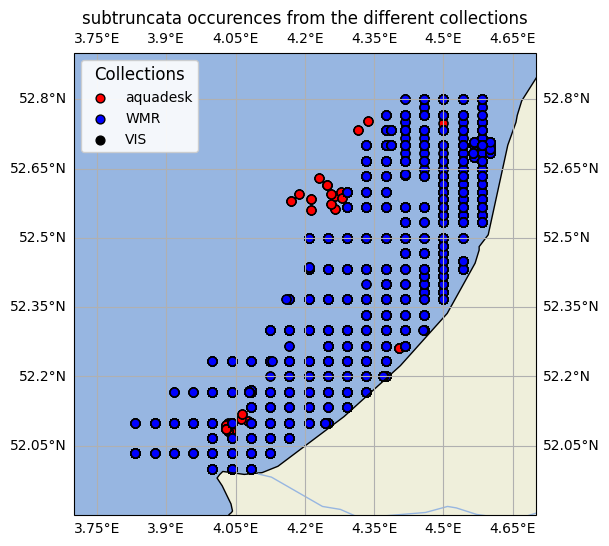

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1], crs=ccrs.PlateCarree())  # (west, east, south, north)
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)
ax.scatter(
    df_Aquadesk_noordzee['longitude'], df_Aquadesk_noordzee['latitude'],
    s=40, edgecolor='black', color='red', label='aquadesk', transform=ccrs.PlateCarree())
ax.scatter(
    df_WMR['longitude'], df_WMR['latitude'],
    s=40, edgecolor='black', color='blue', label='WMR', transform=ccrs.PlateCarree())
ax.scatter(
    df_VIS['longitude'], df_VIS['latitude'],
    s=40, edgecolor='black', color='black', label='VIS', transform=ccrs.PlateCarree())

legend = plt.legend(
    title="Collections", loc="upper left", fontsize=10, title_fontsize=12, frameon=True
)
legend.get_frame().set_alpha(0.9) 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)    
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1)  
plt.title(f'{species} occurences from the different collections')
plt.show()

In [11]:
RWS_CTD_body = {
        "query_parameters": [
            {
                "column_name": 'numeriekewaarde',
                "alias": 'value'
            },
            {
                "column_name": "grootheidcode",
                "alias": "parameter"
            },
            {
                "column_name": "eenheidcode",
                "alias": "unit"
            },
            {
                "column_name": "begindatum",
                "alias": "date"
            },
            {
                "column_name": "longitude",
                "alias": "longitude"
            },
            {
                "column_name": "latitude",
                "alias": "latitude"
            }],
            "filters": [
            {
              "for_query_parameter": "longitude",
              "min": lon_min,
              "max": lon_max
            },
            {
              "for_query_parameter": "latitude",
              "min": lat_min,
              "max": lat_max
            },
            {
              "for_query_parameter": "parameter",
              "eq": parameter_CTD
            },
            {
              "for_query_parameter": "value",
              "min": min_value_CTD,
              "max": max_value_CTD
            },
            {
              "for_query_parameter": "date",
              "min": f"{start_date}T00:00:00",
              "max": f"{end_date}T00:00:00",
              "cast": "timestamp"
            }
            ],
            "output": {
                "format": "csv"
        }}

In [12]:
RWS_CTD_response = requests.post("https://beacon-poc-rws-ctd.maris.nl/api/query", json.dumps(RWS_CTD_body), headers = {
    'Content-type': 'application/json'
})

if RWS_CTD_response.status_code == 200:
    open('./RWS_CTD.csv', 'wb').write(RWS_CTD_response.content)
    df_RWS_CTD = pd.read_csv('RWS_CTD.csv')
    df_RWS_CTD['collection'] = 'CTD'
    df_RWS_CTD.drop(columns='dataset_id', inplace=True)
    df_RWS_CTD['date'] = pd.to_datetime(df_RWS_CTD["date"], dayfirst=False)
    df_RWS_CTD = df_RWS_CTD.sort_values(by='date').reset_index(drop=True)
    print("This is the dataframe generated from the RWS CTD collection."), display(df_RWS_CTD)
else:
    df_RWS_CTD = pd.DataFrame(columns=['value', 'parameter', 'unit', 'date', 'longitude', 'latitude', 'collection'])  
    print("No response content, created an empty DataFrame.")

This is the dataframe generated from the RWS CTD collection.


,value,parameter,unit,date,longitude,latitude,collection
0,6.6810,T,oC,2016-02-15 15:10:00,4.3025,52.30222,CTD
1,6.7420,T,oC,2016-02-15 15:10:00,4.3025,52.30222,CTD
2,6.7432,T,oC,2016-02-15 15:10:00,4.3025,52.30222,CTD
3,6.7467,T,oC,2016-02-15 15:10:00,4.3025,52.30222,CTD
4,6.7459,T,oC,2016-02-15 15:10:00,4.3025,52.30222,CTD
...,...,...,...,...,...,...,...
434595,8.8369,T,oC,2019-04-15 12:56:00,4.1750,52.34167,CTD
434596,8.8390,T,oC,2019-04-15 12:56:00,4.1750,52.34167,CTD
434597,8.8389,T,oC,2019-04-15 12:56:00,4.1750,52.34167,CTD
434598,8.8334,T,oC,2019-04-15 12:56:00,4.1750,52.34167,CTD


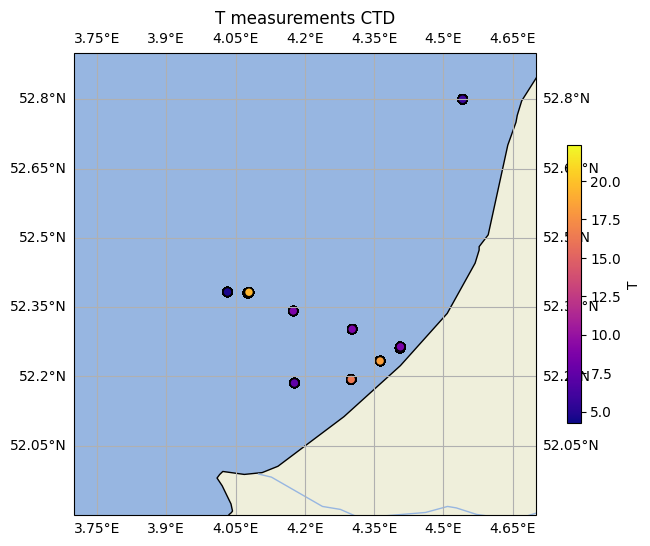

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1], crs=ccrs.PlateCarree())  # (west, east, south, north)
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)
sc = ax.scatter(df_RWS_CTD['longitude'], df_RWS_CTD['latitude'], c=df_RWS_CTD['value'], cmap='plasma', s=40, edgecolor='black', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)   
ax.add_feature(cfeature.BORDERS)  
ax.add_feature(cfeature.LAKES, alpha=0.1)  
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6, label='Value Set 1')
cbar.set_label(f'{parameter_CTD}')
plt.title(f'{parameter_CTD} measurements CTD')
plt.show()

In [14]:
RWS_WADAR_beta_body = {
        "query_parameters": [
            {
                "column_name": "Waarde_Numeriek",
                "alias": "value"
            },
            {
                "column_name": "Meta.Grootheid.Oms",
                "alias": "parameter"
            },
            {
                "column_name": "Meta.Eenheid",
                "alias": "unit"
            },
            {
                "column_name": "Tijdstip",
                "alias": "date"
            },
            {
                "column_name": "Loc.Lon",
                "alias": "longitude"
            },
            {
                "column_name": "Loc.Lat",
                "alias": "latitude"
            }],
            "filters": [
            {
              "for_query_parameter": "longitude",
              "min": lon_min,
              "max": lon_max
            },
            {
              "for_query_parameter": "latitude",
              "min": lat_min,
              "max": lat_max
            },
            {
              "for_query_parameter": "parameter",
              "eq": parameter_WADAR
            },
            {
              "for_query_parameter": "value",
              "min": min_value_WADAR,
              "max": max_value_WADAR
            },
            {
              "for_query_parameter": "date",
              "min": f"{start_date}T00:00:00",
              "max": f"{end_date}T00:00:00",
              "cast": "timestamp"
            }
            ],
            "output": {
                "format": "csv"
        }}

In [15]:
RWS_WADAR_beta_response = requests.post("https://beacon-poc-wadar.maris.nl/api/query", json.dumps(RWS_WADAR_beta_body), headers = {
    'Content-type': 'application/json'
})

if RWS_CTD_response.status_code == 200:
    open('./RWS_WADAR_beta.csv', 'wb').write(RWS_WADAR_beta_response.content)
    df_RWS_WADAR_beta = pd.read_csv('RWS_WADAR_beta.csv', low_memory = False)
    df_RWS_WADAR_beta['collection'] = 'WADAR'
    df_RWS_WADAR_beta.drop(columns='dataset_id', inplace=True)
    df_RWS_WADAR_beta['date'] = pd.to_datetime(df_RWS_WADAR_beta["date"], dayfirst=False)
    df_RWS_WADAR_beta = df_RWS_WADAR_beta.sort_values(by='date').reset_index(drop=True)
    print("This is the dataframe generated from the WADAR BETA collection."), display(df_RWS_WADAR_beta)
else:
    df_RWS_WADAR_beta = pd.DataFrame(columns=['value', 'parameter', 'unit', 'date', 'longitude', 'latitude', 'collection'])  
    print("No response content, created an empty DataFrame.")

This is the dataframe generated from the WADAR BETA collection.


,value,parameter,unit,date,longitude,latitude,collection
0,9.9,Temperatuur,graad Celsius,2016-01-01 00:00:00,4.057019,52.549225,WADAR
1,9.7,Temperatuur,graad Celsius,2016-01-01 00:00:00,4.554823,52.462326,WADAR
2,9.7,Temperatuur,graad Celsius,2016-01-01 00:00:00,4.554823,52.462326,WADAR
3,9.9,Temperatuur,graad Celsius,2016-01-01 00:00:00,4.057019,52.549225,WADAR
4,9.7,Temperatuur,graad Celsius,2016-01-01 00:10:00,4.554823,52.462326,WADAR
...,...,...,...,...,...,...,...
1376547,8.7,Temperatuur,graad Celsius,2023-12-31 23:50:00,4.554823,52.462326,WADAR
1376548,9.6,Temperatuur,graad Celsius,2024-01-01 00:00:00,4.057019,52.549225,WADAR
1376549,9.6,Temperatuur,graad Celsius,2024-01-01 00:00:00,4.057019,52.549225,WADAR
1376550,8.7,Temperatuur,graad Celsius,2024-01-01 00:00:00,4.554823,52.462326,WADAR


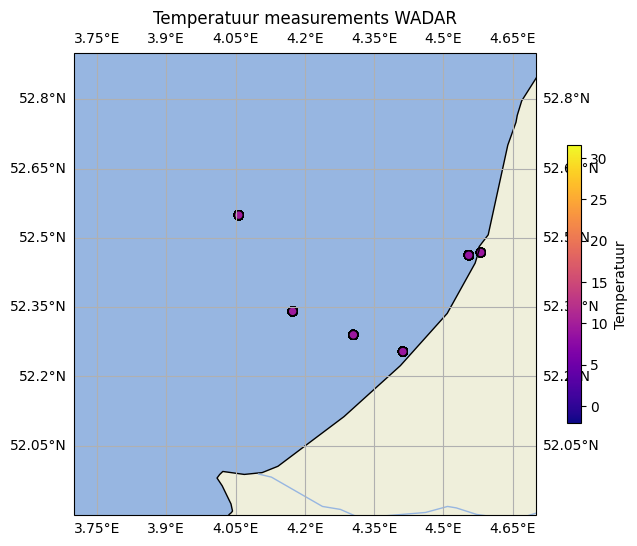

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1], crs=ccrs.PlateCarree())  # (west, east, south, north)
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)
sc = ax.scatter(df_RWS_WADAR_beta['longitude'], df_RWS_WADAR_beta['latitude'], c=df_RWS_WADAR_beta['value'], cmap='plasma', s=40, edgecolor='black', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)    
ax.add_feature(cfeature.BORDERS) 
ax.add_feature(cfeature.LAKES, alpha=0.1)  
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6, label='Value Set 1')
cbar.set_label(f'{parameter_WADAR}')
plt.title(f'{parameter_WADAR} measurements WADAR')
plt.show()

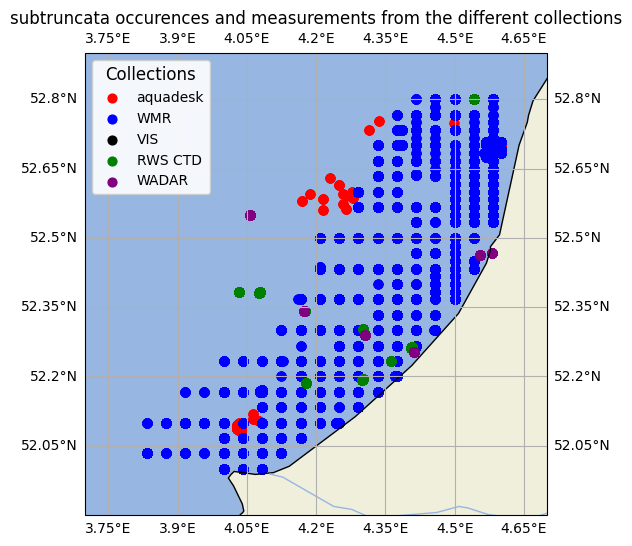

In [17]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min - 0.1, lon_max + 0.1, lat_min - 0.1, lat_max + 0.1], crs=ccrs.PlateCarree())  # (west, east, south, north)
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)
ax.scatter(
    df_Aquadesk_noordzee['longitude'], df_Aquadesk_noordzee['latitude'],
    s=40, color='red', label='aquadesk', transform=ccrs.PlateCarree())

ax.scatter(
    df_WMR['longitude'], df_WMR['latitude'],
    s=40, color='blue', label='WMR', transform=ccrs.PlateCarree())

ax.scatter(
    df_VIS['longitude'], df_VIS['latitude'],
    s=40, color='black', label='VIS', transform=ccrs.PlateCarree())

ax.scatter(
    df_RWS_CTD['longitude'], df_RWS_CTD['latitude'],
    s=40, color='green', label='RWS CTD', transform=ccrs.PlateCarree())

ax.scatter(
    df_RWS_WADAR_beta['longitude'], df_RWS_WADAR_beta['latitude'],
    s=40, color='purple', label='WADAR', transform=ccrs.PlateCarree())

legend = plt.legend(
    title="Collections", loc="upper left", fontsize=10, title_fontsize=12, frameon=True
)
legend.get_frame().set_alpha(0.9) 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)  
ax.add_feature(cfeature.LAKES, alpha=0.1)  
plt.title(f'{species} occurences and measurements from the different collections')
plt.show()

In [18]:
non_empty_dfs = [df for df in [df_VIS, df_Aquadesk_noordzee, df_WMR] if not df.empty]
merged_df = pd.concat(non_empty_dfs, ignore_index=True)
species_df = merged_df.loc[(merged_df["unit"] == "n") | (merged_df["unit"] == "n/m2")] #Is not correct, but included like this to show the concept
time_series = species_df.groupby(pd.Grouper(key="date", freq="ME"))["value"].sum().reset_index()
time_series.set_index("date", inplace=True)
time_series = time_series.sort_index()

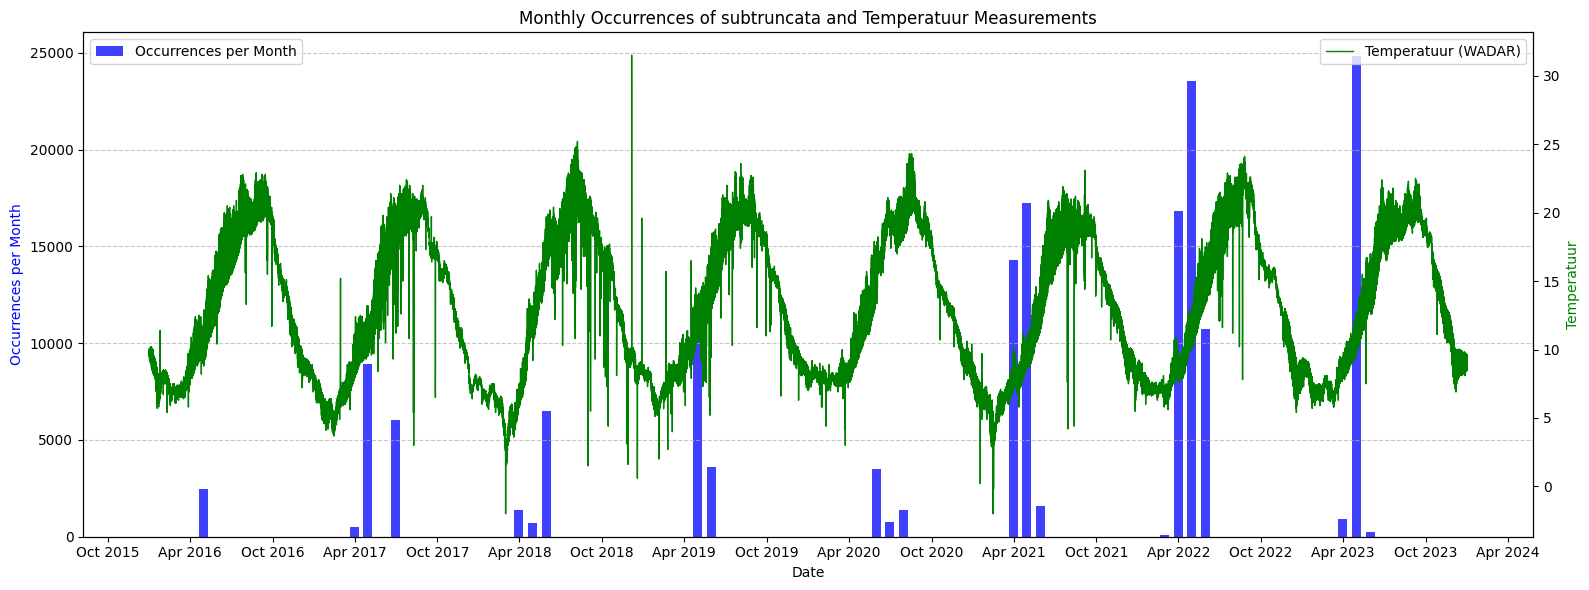

In [19]:
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.bar(
    time_series.index,
    time_series['value'],
    width=20,
    color='blue',
    alpha=0.75,
    label='Occurrences per Month')

ax2 = ax1.twinx()  
ax2.plot(
    df_RWS_WADAR_beta['date'],
    df_RWS_WADAR_beta['value'],
    color='green',
    linewidth=1,
    label= f'{parameter_WADAR} (WADAR)'
)

ax1.set_title(f"Monthly Occurrences of {species} and {parameter_WADAR} Measurements")
ax1.set_xlabel("Date")
ax1.set_ylabel("Occurrences per Month", color='blue')
ax2.set_ylabel(f'{parameter_WADAR}', color='green')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6)) 
ax1.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.xticks(rotation=45)  
plt.show()

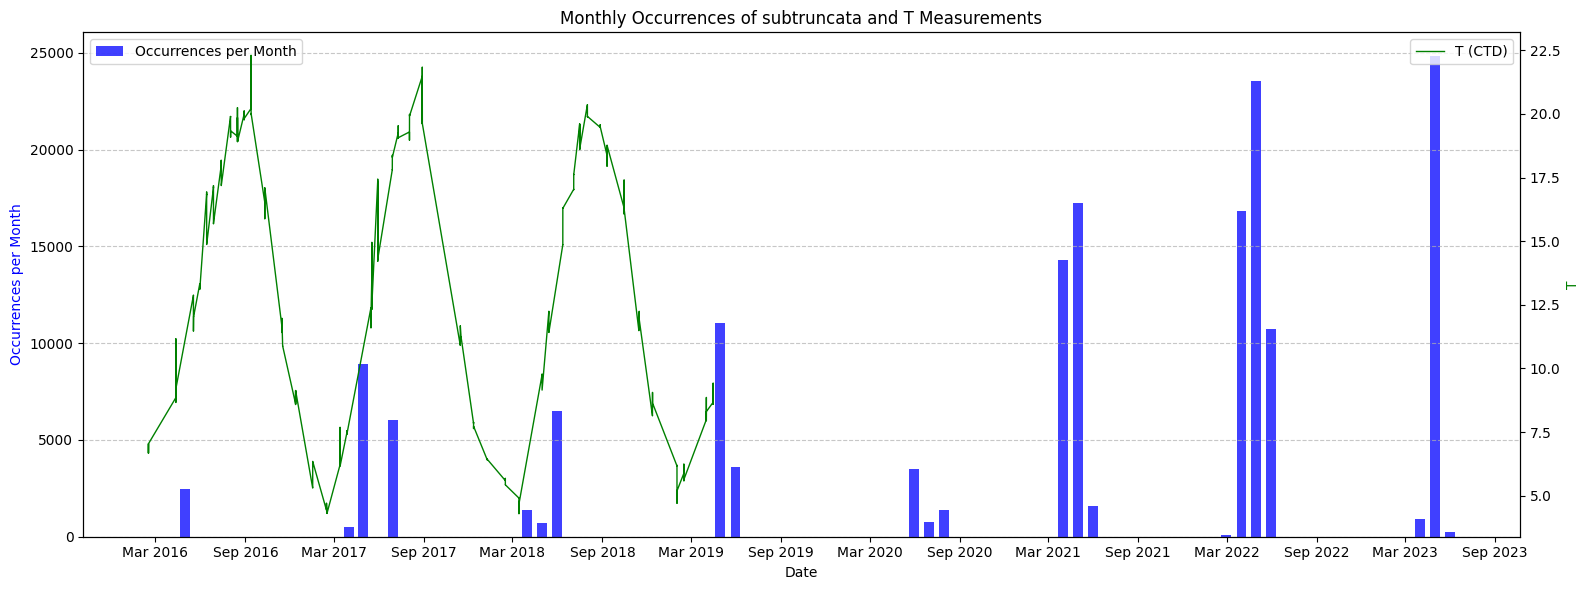

In [20]:
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.bar(
    time_series.index,
    time_series['value'],
    width=20,
    color='blue',
    alpha=0.75,
    label='Occurrences per Month')

ax2 = ax1.twinx()  
ax2.plot(
    df_RWS_CTD['date'],
    df_RWS_CTD['value'],
    color='green',
    linewidth=1,
    label= f'{parameter_CTD} (CTD)'
)

ax1.set_title(f"Monthly Occurrences of {species} and {parameter_CTD} Measurements")
ax1.set_xlabel("Date")
ax1.set_ylabel("Occurrences per Month", color='blue')
ax2.set_ylabel(f'{parameter_CTD}', color='green')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  
ax1.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.xticks(rotation=45)  
plt.show()